In [60]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt
SEED=888

In [61]:
train=pd.read_csv('bike_train.csv')
train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [62]:
# parse datetime fields

def parse_datetime(df):
    df['datetime']=pd.to_datetime(df['datetime'])
    df['year']=df.datetime.dt.year
    df['month']=df.datetime.dt.month
    df['hour']=df.datetime.dt.hour
    df.drop('datetime',axis=1,inplace=True)

parse_datetime(train)

train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4


In [63]:
# submission test file
sub_test=pd.read_csv('bike_test.csv')

parse_datetime(sub_test)
sub_test.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1


In [64]:
# Generate X and y datasets
X=train.drop(['casual','registered','count'],axis=1)

y=train['count']


In [65]:
# Train and test dataset split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=SEED)

In [66]:
# train a simple decision tree model and compute the RMSE
dt=DecisionTreeRegressor(random_state=SEED)
dt.fit(X_train,y_train)

dt_pred=dt.predict(X_test)
dt_rmse=MSE(y_test,dt_pred)**(1/2)
print('The RMSE of a simple decision tree is:{:.2f}'.format(dt_rmse))

The RMSE of a simple decision tree is:61.96


In [67]:
# train a random forest model to compare
rf=RandomForestRegressor(random_state=SEED)
rf.fit(X_train,y_train)

rf_pred=rf.predict(X_test)
rf_rmse=(MSE(y_test,rf_pred))**(1/2)
print('The RMSE of Random Forest is: {:.2f}'.format(rf_rmse))

The RMSE of Random Forest is: 44.25


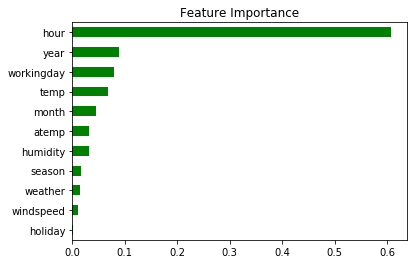

In [68]:
# plot the feature importance graph
importances=pd.Series(data=rf.feature_importances_,index=X_train.columns)
importances_sorted=importances.sort_values()
importances_sorted.plot(kind='barh',color='green')
plt.title('Feature Importance')
plt.show()

In [69]:
# gradient boosting model, compute RMSE
gb=GradientBoostingRegressor(max_depth=6,n_estimators=200,random_state=SEED)
gb.fit(X_train,y_train)
gb_pred=gb.predict(X_test)

gb_RMSE=(MSE(y_test,gb_pred))**(1/2)
print('The RMSE of Gradient Boosting Model is:{:.2f}'.format(gb_RMSE))

The RMSE of Gradient Boosting Model is:39.88


In [70]:
# stochastic gradient boosting model,compute RMSE
sgbr=GradientBoostingRegressor(random_state=SEED)
sgbr.fit(X_train,y_train)
sgbr_pred=sgbr.predict(X_test)
sgbr_RMSE=(MSE(y_test,sgbr_pred))**(1/2)
print('The RMSE of Stochastic Gradient Boosting Model is:{:.2f}'.format(sgbr_RMSE))

The RMSE of Stochastic Gradient Boosting Model is:66.10


In [58]:
# parameters tuning on random forest
params_rf={'n_estimators':[100,350,500],
          'max_features':['log2','auto','sqrt'],
          'min_samples_leaf':[2,10,30]}

param_cv=GridSearchCV(estimator=rf,
                     param_grid=params_rf,
                     scoring='neg_mean_squared_error',
                     cv=5,
                     verbose=1,
                     n_jobs=-1)

param_cv.fit(X_train,y_train)
best_model=param_cv.best_estimator_

param_pred=best_model.predict(X_test)
param_RMSE=(MSE(y_test,param_pred))**(1/2)
print('The RMSE of parameter tuned model is: {:.2f} '.format(param_RMSE))

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.1min finished


The RMSE of parameter tuned model is: 42.77 


In [71]:
# parameters tuning on stochastic gradient boosting model
param_sgbr={'max_depth':[4,6,8],
           'subsample':[0.75,0.85,0.9],
           'n_estimators':[300,400,500,600]}

param_sgbr=GridSearchCV(estimator=sgbr,
                       param_grid=param_sgbr,
                       scoring='neg_mean_squared_error',
                       cv=10,
                       verbose=1,
                       n_jobs=-1)

param_sgbr.fit(X_train,y_train)
best_model=param_sgbr.best_estimator_

param_sgbr_pred=best_model.predict(X_test)
param_sgbr_RMSE=(MSE(y_test,param_sgbr_pred))**(1/2)
print('The RMSE of parameter tuned SGBR model is: {:.2f}'.format(param_sgbr_RMSE))

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.7min finished


The RMSE of parameter tuned SGBR model is: 39.63


In [72]:
best_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=888,
             subsample=0.85, verbose=0, warm_start=False)